## **Seattle Airbnb data analysis**

### **Business Understanding**

**My Seattle Airbnb data analysis project** uses three datasets about booking calendar, listings, reviews. \
By conducting various analyses, my aim is to answer the following three questions regarding pricing trends and occupancy rates of Airbnb across different seasons and neighborhoods in Seattle: 
1. *How do average nightly prices vary by neighborhood?*
2. *What are the peak pricing months in Seattle? Do monthly average nightly price highly correlate with occupancy rate?*
3. *How do high-rated listings compare in occupancy rate to lower-rated ones?*


### **Data Understanding**

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
# Import datasets
calendar_df = pd.read_csv('seattle-airbnb/calendar.csv')
listings_df = pd.read_csv('seattle-airbnb/listings.csv')
reviews_df = pd.read_csv('seattle-airbnb/reviews.csv')

In [3]:
calendar_df.sample(2)

,listing_id,date,available,price
1049173,3412630,2016-06-15,t,$295.00
1032231,8273031,2016-01-15,t,$350.00


In [4]:
min(calendar_df['date'])

'2016-01-04'

In [5]:
max(calendar_df['date'])

'2017-01-02'

- The **Calendar Dataset** contains information on listing availability and nightly prices, including listing ID, date, availability status, and price. 

In [6]:
listings_df.sample(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
3063,170469,https://www.airbnb.com/rooms/170469,20160104002432,2016-01-04,Private Bed & Bath in Ballard,Your cozy room with full-sized bed includes a ...,Your private bedroom with attached bath is on ...,Your cozy room with full-sized bed includes a ...,none,"Ballard is very popular with trendy shops, bar...",...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
2328,7809455,https://www.airbnb.com/rooms/7809455,20160104002432,2016-01-04,Private Room in Family Home,15 min. to airport and downtown. Room has doub...,This bedroom is in the basement of our family ...,15 min. to airport and downtown. Room has doub...,none,Hillman City/Seward Park is a family-friendly ...,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.44


In [7]:
listings_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

- The **Listings Dataset** provides detailed information about each listing, such as listing ID, name, neighborhood, property type, number of bedrooms, and review scores.

In [8]:
reviews_df.sample(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments
32009,611500,17540766,2014-08-13,7386921,Steve,Staying with Prez and Cherie was a wonderful e...
20083,902609,10825020,2014-03-09,8614940,Rachael,I was in Seattle for three nights for school -...


- The **Reviews Dataset** includes guest reviews with fields like review ID, listing ID, date of review, reviewer ID, reviewer name, and review comments.

In [9]:
min(reviews_df['date'])

'2009-06-07'

In [10]:
max(reviews_df['date'])

'2016-01-03'

- Calendar dataset date range is from *2016-01-04* to *2017-01-02*, review dataset date range is from *2009-06-07* to *2016-01-03*, so all reviews had been done before the bookings.

In [11]:
calendar_df['null_price'] = calendar_df['price'].isnull()
calendar_df[['available','null_price']].value_counts()

available  null_price
t          False         934542
f          True          459028
Name: count, dtype: int64

In [12]:
# clearn 'price' column
calendar_df['price'] = calendar_df['price'].str.replace('$', '').str.replace(',', '').astype(float)

 - The price column is null when the available column is 'f' (false), meaning the listing is occupied on those days. Therefore, the price column is only populated for unoccupied (available) days.
 - Given this information, the analysis of average nightly prices by neighborhood and peak pricing seasons is valid for available days only.

In [13]:
reviews_df.isnull().sum()

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         18
dtype: int64

The **Reviews Dataset** includes guest reviews with fields like review ID, listing ID, date of review, reviewer ID, reviewer name, and review comments

- Only comments column in reviews dataset has null values and that is a normal behavior (rating without leaving any comments)

In [14]:
rating_df = listings_df[['id','review_scores_rating']]

In [15]:
rating_df.isnull().sum()

id                        0
review_scores_rating    647
dtype: int64

In [16]:
rating_df.shape

(3818, 2)

There are 647/3818 rows having null values in review_scores_rating column, I'm gonna drop these rows

In [17]:
rating_df = rating_df.dropna()

### **Prepare data**

In [18]:
# pick relevant columns
calendar_df_1 = calendar_df[['listing_id', 'date', 'price','available']]
listings_df_2 = listings_df[['id', 'neighbourhood_cleansed']]

# join 2 datasets
calendar_listing_merged_df = pd.merge(calendar_df_1,listings_df_2, left_on= 'listing_id',right_on= 'id')

# calculate average price by neighbourhoods
avg_price_by_neighborhood = calendar_listing_merged_df.groupby('neighbourhood_cleansed')['price'].mean().reset_index()
avg_price_by_neighborhood.columns = ['neighbourhood_cleansed', 'avg_price']
avg_price_by_neighborhood.head(5)

,neighbourhood_cleansed,avg_price
0,Adams,130.678714
1,Alki,187.145535
2,Arbor Heights,139.928058
3,Atlantic,122.856707
4,Belltown,201.472843


In [19]:

# convert the date column to datetime
calendar_listing_merged_df['date'] = pd.to_datetime(calendar_listing_merged_df['date'])

# extract month from the date
calendar_listing_merged_df['month'] = calendar_listing_merged_df['date'].dt.month

# group by month and calculate the average price
avg_price_by_month = calendar_listing_merged_df.groupby('month')['price'].mean().reset_index()
avg_price_by_month.columns = ['month','avg_price']

# occupancy Rate
occupancy_by_month = calendar_listing_merged_df.groupby('month')['available'].apply(lambda x: (x == 'f').sum()/len(x)).reset_index()
occupancy_by_month.columns = ['month', 'occupancy_rate']

# merge data
avg_price_and_occupancy_by_month = pd.merge(avg_price_by_month, occupancy_by_month, on = 'month')
avg_price_and_occupancy_by_month

,month,avg_price,occupancy_rate
0,1,122.912176,0.433063
1,2,124.293927,0.337792
2,3,128.644488,0.290813
3,4,135.097005,0.336153
4,5,139.538183,0.324330
5,6,147.473137,0.325616
6,7,152.094150,0.372903
7,8,150.656594,0.354949
8,9,143.255949,0.325598
9,10,137.031939,0.303486


In [20]:
# calculate occupancy rate for each listing 
occupancy_rate_by_listing = calendar_df.groupby('listing_id')['available'].apply(lambda x: (x == 'f').sum()/len(x)).reset_index()

# merge data
occupancy_rate_rating_by_listing = pd.merge(occupancy_rate_by_listing, rating_df, left_on = 'listing_id', right_on = 'id', how='inner').drop(columns=['id'])
occupancy_rate_rating_by_listing.columns = ['listing_id','occupancy_rate','review_scores_rating']
occupancy_rate_rating_by_listing.sample(5)

,listing_id,occupancy_rate,review_scores_rating
878,3076065,0.000000,96.0
1955,6490091,0.780822,100.0
1066,3697351,0.095890,87.0
2707,8086294,0.463014,100.0
2192,7018009,0.167123,94.0


### **Question 1**: ***How do average nightly prices vary by neighborhood?***


#### **Analyze and visualize data**

In [21]:
def plot_ecdf_with_percentiles(dataset_name, value_column, xlabel, title):
    """
    Plots the Empirical Cumulative Distribution Function (ECDF) of the average nightly price by neighborhood 
    and highlights the 25th, 50th (median), and 75th percentiles.

    Parameters:
    dataset_name (pandas.DataFrame): The dataset containing neighborhood data.
    value_column (str): The name of the column containing the values to be plotted (e.g., average nightly price).
    xlabel (str): The label for the x-axis.
    title (str): The title of the plot.

    Returns:
    None
    """
    # Sort values and calculate ECDF values
    dataset_sorted = dataset_name.sort_values(by=value_column).reset_index(drop=True)
    dataset_sorted['ecdf_values'] = (dataset_sorted.index + 1) / dataset_sorted.shape[0]

    # Calculate percentiles
    avg_price_q1 = np.percentile(dataset_sorted[value_column], 25)
    avg_price_median = np.percentile(dataset_sorted[value_column], 50)
    avg_price_q3 = np.percentile(dataset_sorted[value_column], 75)

    # Plot ECDF
    plt.figure(figsize=(10, 6))
    plt.plot(dataset_sorted[value_column], dataset_sorted['ecdf_values'], marker='.', linestyle='none')
    plt.xlabel(xlabel)
    plt.ylabel('ECDF')
    plt.title(title)
    plt.grid(True)

    # Format y-axis as percentage
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
    plt.ylim(0, 1)

    # Add percentile lines
    plt.axhline(y=0.25, color='r', linestyle='--', label='Q1 (25th percentile)')
    plt.axhline(y=0.50, color='g', linestyle='--', label='Median (50th percentile)')
    plt.axhline(y=0.75, color='b', linestyle='--', label='Q3 (75th percentile)')

    # Annotate percentiles
    plt.annotate(f'Q1: {avg_price_q1:.2f}', xy=(avg_price_q1, 0.25), xytext=(avg_price_q1, 0.3), 
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10, color='r')
    plt.annotate(f'Median: {avg_price_median:.2f}', xy=(avg_price_median, 0.50), xytext=(avg_price_median, 0.55), 
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10, color='g')
    plt.annotate(f'Q3: {avg_price_q3:.2f}', xy=(avg_price_q3, 0.75), xytext=(avg_price_q3, 0.8), 
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10, color='b')

    plt.legend()
    plt.show()

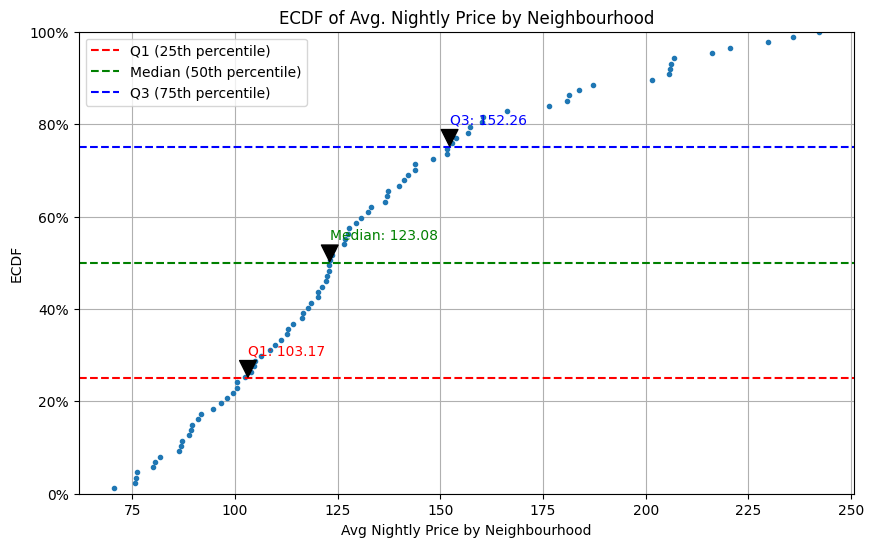

In [22]:
plot_ecdf_with_percentiles(avg_price_by_neighborhood, 'avg_price', 'Avg Nightly Price by Neighbourhood', 'ECDF of Avg. Nightly Price by Neighbourhood')


*5 neighborhood with highest average price nightly:*

In [23]:
avg_price_by_neighborhood[['neighbourhood_cleansed','avg_price']].sort_values(by= 'avg_price', ascending= False).head().reset_index(drop=True)

,neighbourhood_cleansed,avg_price
0,Southeast Magnolia,242.077181
1,Portage Bay,235.960789
2,Westlake,229.757911
3,Windermere,220.630903
4,Briarcliff,216.080733


*5 neighborhood with lowest average price nightly:*

In [24]:
avg_price_by_neighborhood[['neighbourhood_cleansed','avg_price']].head()

,neighbourhood_cleansed,avg_price
0,Adams,130.678714
1,Alki,187.145535
2,Arbor Heights,139.928058
3,Atlantic,122.856707
4,Belltown,201.472843


In [25]:
avg_price_by_neighborhood['avg_price'].describe()

count     87.000000
mean     132.399600
std       40.979621
min       70.560796
25%      103.166337
50%      123.083689
75%      152.257802
max      242.077181
Name: avg_price, dtype: float64

#### **Evaluation**

- We have totally 87 neighborhoods in the dataset with avarage price ranging from ~70.56 USD/night to ~242 USD/night.
- Top 5 neighborhoods by highest average price per night are Southest Magnolia (242 USD/night), Portage Bay, Westlake, Windermere, & Briarcliff (216 USD/night)
- Top 5 neighborhoods by lowest average price per night are Victory Heights, South Delridge, Geogretown, Rainier Beach, & Olymphic Hills with avg price/prices per night are all lower than 80 USD.
- The median of each neighborhood's average price per night is 123 USD/night, 75% of neighborhood have average price per night less than 152 USD, the rest of neighborhoods has average price per night ranging from 152-242 USD

### **Question 2:**  ***What are the peak pricing months in Seattle? Do monthly average nightly price highly correlate with occupancy rate?***


#### **Analyze and visualize data**

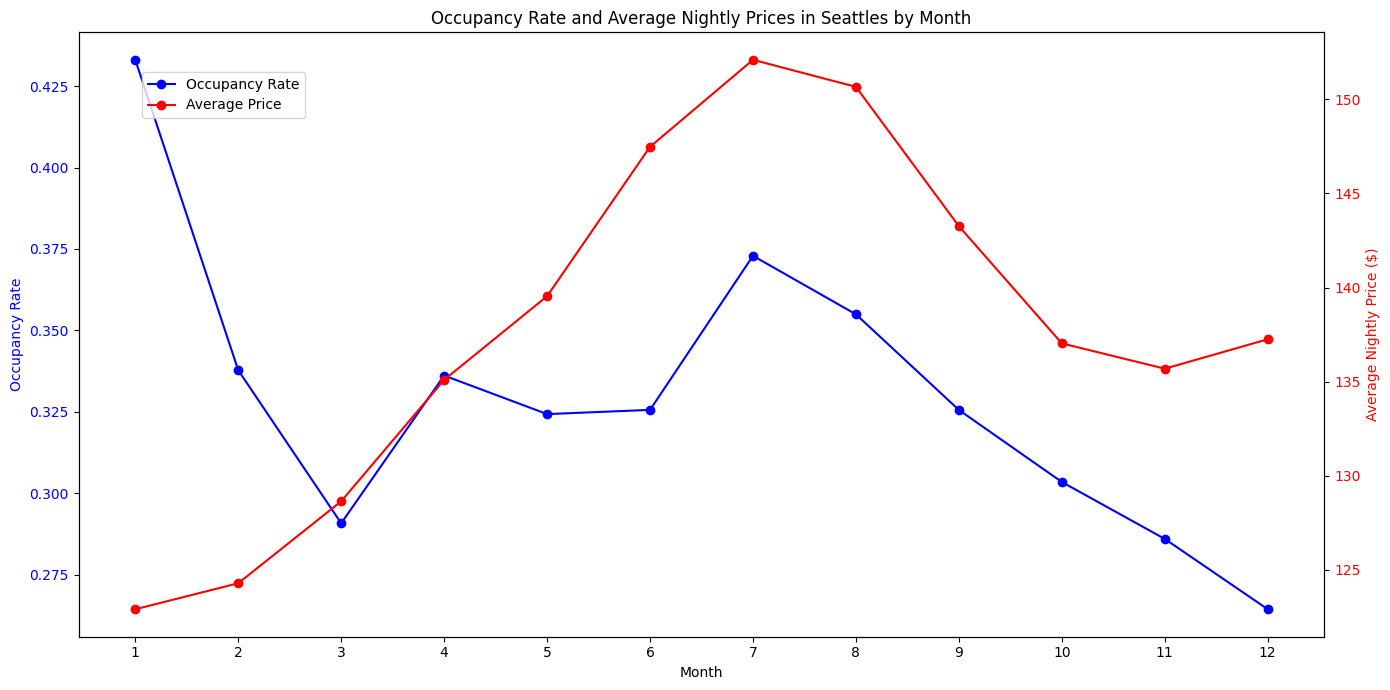

In [26]:
fig, ax1 = plt.subplots(figsize = (14, 7))

# occupancy Rate
ax1.plot(avg_price_and_occupancy_by_month['month'], avg_price_and_occupancy_by_month['occupancy_rate'], 'b', marker = 'o', label='Occupancy Rate')
ax1.set_xlabel('Month')
ax1.set_ylabel('Occupancy Rate', color = 'b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticks(range(1, 13))

# average Price 
ax2 = ax1.twinx()
ax2.plot(avg_price_and_occupancy_by_month['month'], avg_price_and_occupancy_by_month['avg_price'], 'r-', marker = 'o', label='Average Price')
ax2.set_ylabel('Average Nightly Price ($)', color='r')
ax2.tick_params(axis='y', labelcolor='r')


plt.title('Occupancy Rate and Average Nightly Prices in Seattles by Month')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))

In [27]:
# correlation coefficient
corr_price_occupancy = avg_price_and_occupancy_by_month['occupancy_rate'].corr(avg_price_and_occupancy_by_month['avg_price'])
print(corr_price_occupancy)

-0.062419403142019804


In [28]:
# correlation coefficient from march
avg_price_and_occupancy_by_month_from_march = avg_price_and_occupancy_by_month[avg_price_and_occupancy_by_month['month'] >2 ]
corr_price_occupancy_from_march = avg_price_and_occupancy_by_month_from_march['occupancy_rate'].corr(avg_price_and_occupancy_by_month_from_march['avg_price'])
corr_price_occupancy_from_march

0.755855844126509

#### **Evaluation:**
- Although January has the highest occupancy rate, it has the lowest average nightly price in a year.
- The average nightly price is highest in three summer months, from June to August
- December has the lowest occupation rate in the whole year but its average nightly price is fairly high compared to first 4 months of the year.
- The correlation coefficient between monthly Average nightly price and monthly occupation rate is ~-0.062. This indicates a very weak negative correlation, suggesting that there is almost no linear relationship between the two variables, though looking at the chart from March to December, they seem to be correlated.

### **Question 3:** ***How do high-rated listings compare in occupancy rate to lower-rated ones?***


#### **Analyze and visualize data**

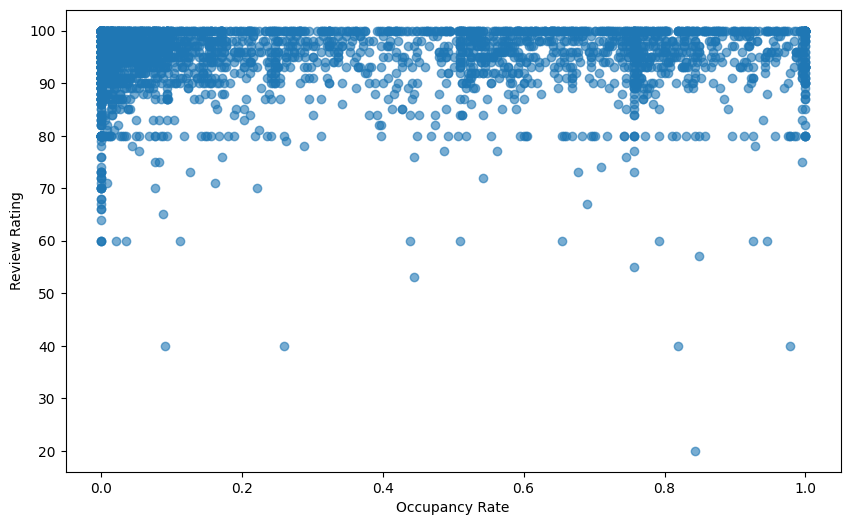

In [29]:
plt.figure(figsize=(10, 6))
plt.scatter(occupancy_rate_rating_by_listing['occupancy_rate'],occupancy_rate_rating_by_listing['review_scores_rating'],alpha = 0.6)
plt.xlabel('Occupancy Rate')
plt.ylabel('Review Rating')
plt.show()

- We can't see a clear linear relationship between Review Rating and Occupancy Rate here 

<Axes: >

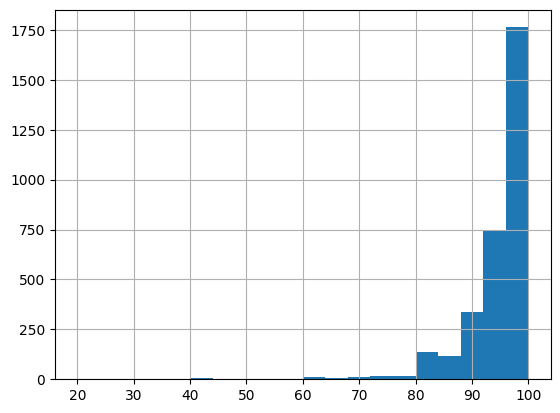

In [30]:
listings_df['review_scores_rating'].hist(bins = 20)

- Most of the ratings are higher than 80.

In [31]:
# Define high-rated and low-rated thresholds
high_rating_threshold = 95
low_rating_threshold = 80

# Categorize listings into high-rated and low-rated
occupancy_rate_rating_by_listing['rating_category'] = occupancy_rate_rating_by_listing['review_scores_rating'].apply(
    lambda x: 'High' if x >= high_rating_threshold else ('Low' if x <= low_rating_threshold else 'Medium')
)
occupancy_rate_rating_by_listing.sample(5)

,listing_id,occupancy_rate,review_scores_rating,rating_category
3033,9138923,0.035616,100.0,High
1805,6115807,0.561644,96.0,High
1214,4069543,0.073973,98.0,High
1335,4430233,0.068493,90.0,Medium
2581,7859909,0.000000,89.0,Medium


In [32]:
# calculate average occupancy rates for each rating category
average_occupancy_rates = occupancy_rate_rating_by_listing.groupby('rating_category')['occupancy_rate'].mean().reset_index()
average_occupancy_rates


,rating_category,occupancy_rate
0,High,0.328173
1,Low,0.323711
2,Medium,0.293814


In [33]:
corr_coef_2 = occupancy_rate_rating_by_listing['occupancy_rate'].corr(occupancy_rate_rating_by_listing['review_scores_rating'])
print('Correlation coefficient of Occupancy Rate and Rating of each Listing: ', corr_coef_2)

Correlation coefficient of Occupancy Rate and Rating of each Listing:  0.0386001924089593


#### **Evaluation:**
- High-rated listings have an average occupancy rate of approximately 32.28%, Low-rated listings have an average occupancy rate of approximately 32.37%, Medium-rated listings fall in between with an average occupancy rate of approximately 29.38%.
- Correlation coefficient of Occupancy Rate and Rating of each Listing is 0.04, this indicates a very weak linear relationship between occupancy rate and listing rating.
- Possible Reasons:
    - Pricing and Location: Factors such as pricing strategy, location, and seasonality could play a more significant role in determining occupancy rates than the ratings themselves.

    - Review Volume: The number of reviews or recency of reviews might affect occupancy more than the average rating.

    - Listing Characteristics: Features like amenities, host responsiveness, and marketing could also impact occupancy rates independently of ratings.

### **Summarize key findings**

Our analysis reveals valuable trends in the Seattle Airbnb market:

- Neighbourhoods with certain geographic traits command higher prices.
- Summer months are the most profitable for rentals.
- Reviews, while important, are just one of many factors influencing occupancy rates.